# Fifteen factorization using Shor's algorithm

This is a compiled circuit taken from reference [1804.03719](https://arxiv.org/abs/1804.03719). It uses information about
the target number to simplify a lot the gates needed. We will factorize the number `N = 15`, using the base `a = 11`.
The circuit is run in both a simulator and a quantum computer, courtesy of IBM's Quantum Platform. Here are the required Qiskit 1.0 imports:

In [1]:
from math import pi
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

### Circuit definition

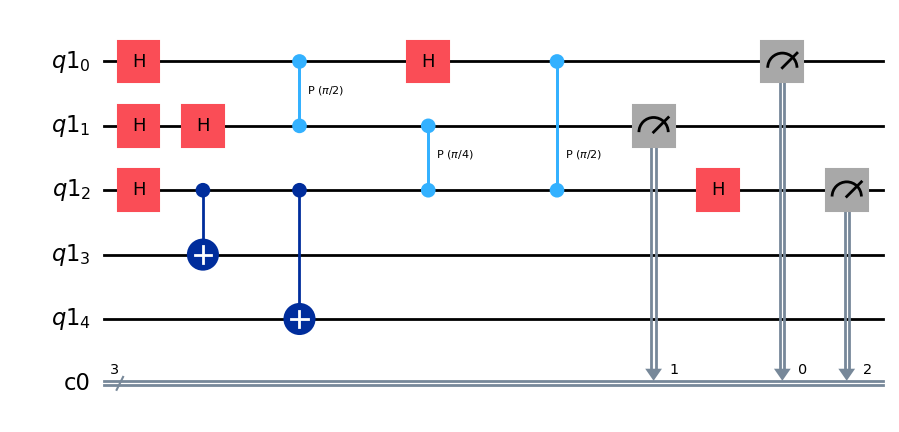

In [2]:
# Define quantum and classical registers
qr = QuantumRegister(5)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

# Constructing the quantum circuit
qc.h([0, 1, 2])
qc.cx(2, 3)
qc.cx(2, 4)
qc.h(1)
qc.cp(pi/2, 1, 0)
qc.h(0)
qc.cp(pi/4, 1, 2)
qc.cp(pi/2, 0, 2)
qc.h(2)

# Measurement
for i in range(3):
    qc.measure(i, i)

# Display
qc.draw(output="mpl")

## Run in simulator

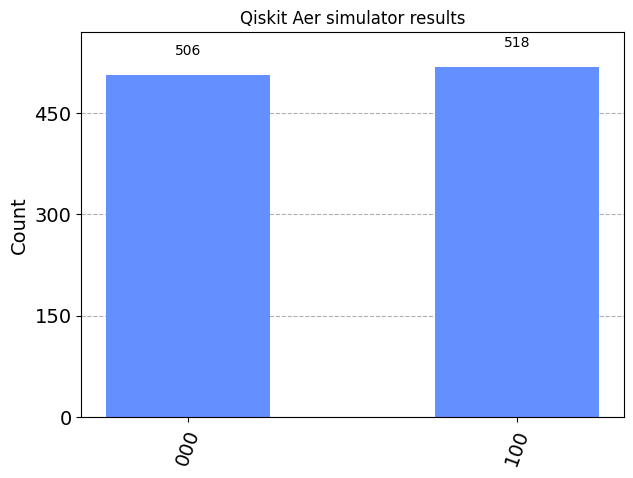

In [3]:

# Execute the circuit on a quantum simulator
backend = AerSimulator()
counts = backend.run(transpile(qc, backend)).result().get_counts()
plot_histogram(counts, title="Qiskit Aer simulator results")

## Run in IBM's Eagle quantum computer

### Circuit transpilation

In [6]:
# Credentials and service initiation
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="YOUR_API_KEY",)

# Set sample and backend
backend = service.least_busy(simulator=False, operational=True)
print(backend.name)

# Transpile circuit
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled = pass_manager.run(qc)

ibm_kyoto


### Run in the QPU

>>> Job ID: crqsved2x9jg008z2r50
>>> Job Status: JobStatus.QUEUED


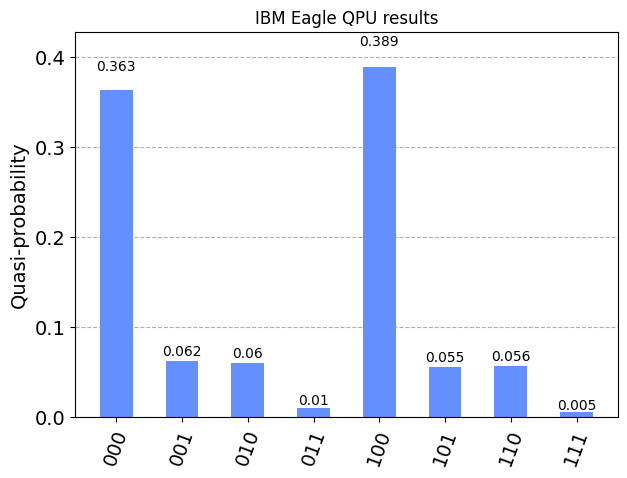

In [7]:
# Execute using Qiskit primitives
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=transpiled,
        skip_transpilation=True,
        shots=1024,
    )

    # Run the transpiled circuit
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    result = job.result()

# Wait for the job to complete and retrieve the results
counts = [dist.binary_probabilities() for dist in result.quasi_dists]

# Display the results
plot_histogram(counts, title="IBM Eagle QPU results")

## Judgement

Both the classical simulation and the Eagle QPU results present two prominent peaks. The 0 one corresponds to the trivial
period, but the second one `100` (4) is correct. We know that the circuit's counts peak at a number that is proportional
to $\frac{2^n}{r}$, where $n$ is the number of qubits in the control register and $r$ is the period. We have then:

$r = \frac{2^3}{4} = 2$

We know that for a target number $N$ and a base $a$:

$N = \prod_{i=0}^1 \text{gcd}(a^{\frac{r}{2}} + (-1)^i, N)$

Which means:

$15 = \prod_{i=0}^1 \text{gcd}(11^{\frac{2}{2}} + (-1)^i, 15) = 3 \times 5$